In [1]:
import copy 
import time
import pickle 
import warnings
import scipy
import scipy.sparse
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import torch
import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from matplotlib import cm # Colormaps

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "/Users/ymohit/sgkigp/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98793/3777520146.py:11: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
from sgkigp.interp.rectgrid import grid_points
from sgkigp.interp.simplicial import get_simplicial_basis
import sgkigp.tensorize as InterpolationUtils
from sgkigp.interp.rectgrid import grid_coords

In [3]:
def inv_permutation(I, device=None):

    # TODO: fix torch long d-type issue
    n, d = I.shape
    J = np.zeros_like(I)
    np.put_along_axis(J, I, np.arange(d), 1)
    return J

In [4]:
xmin=-1
xmax=1
func = lambda X: np.sin(np.sum(X, axis=1))

test_dim=3
ndim = 3
dim_points = 5
ntrain = 2
grid = [(xmin, xmax, dim_points)]*ndim
test_grid = [(xmin, xmax, test_dim)]*ndim

#x = grid_points(test_grid)

x = np.random.rand(ntrain, ndim)*2 -1

n, d = x.shape

# Get info about grid
coords = grid_coords(grid)
spacing = np.array([c[1] - c[0] for c in coords])
origin = np.array([c[0] for c in coords])
grid_sz = tuple(g[2] for g in grid)

# Get grid cell multi_index and local coordinates for each data point
grid_multi_index = np.floor(((x - origin) / spacing)).astype(int)
grid_point = origin + grid_multi_index * spacing
local_coords = (x - grid_point) / spacing

assert np.allclose(x, origin + grid_multi_index * spacing + local_coords * spacing)
assert np.allclose(x, grid_point + local_coords * spacing)

# Each data point will have d+1 neighboring grid points
# (the corners of the simplex containing the point)

# Get the d+1 basis values for each data point
sorted_coords = np.sort(local_coords, axis=1)
basis_values_rev = np.hstack((sorted_coords[:, 0, None],
                              np.diff(sorted_coords, axis=1),
                              1 - sorted_coords[:, -1, None]))  # n x d+1
basis_values = np.flip(basis_values_rev, axis=1)  # n x d+1

# Construct the reference simplex. It looks like this. Note
# that row's coordinates are monotonically non-decreasing
#     [[0 0 0]
#      [0 0 1]
#      [0 1 1]
#      [1 1 1]]
reference_simplex_corners = np.vstack((np.zeros(d), np.tril(np.ones(d))[:, ::-1])).astype('int')  # d+1 x d

print("Simplex corners: ", reference_simplex_corners)

# The neighbors are obtained by sorting the coordinates (columns) of
# the reference simplex so they follow the same sorting order as the
# local coordinates. That is, we sort the reference coordinates by
# the inverse argsort of the local coordinates
I = np.argsort(local_coords, axis=1)  # n x d

print("L, I: ", local_coords, I)
J = inv_permutation(I)  # n x d
print("J:", J)
neighbor_offsets = reference_simplex_corners[:, J]  # d+1 x n x d

# Compute indices of neighbors
#neighbor_multi_indices = np.transpose(grid_multi_index + neighbor_offsets, (2, 1, 0))  # d x n x d+1
neighbor_multi_indices = np.transpose(neighbor_offsets, (2, 1, 0))  # d x n x d+1
print('Neighbours: ', neighbor_multi_indices.shape)
print(neighbor_multi_indices.squeeze())
# neighbor_indices = np.ravel_multi_index(tuple(neighbor_multi_indices), grid_sz, mode='clip')  # n x d+1

# data_point_indices = np.repeat(np.arange(n), d + 1).ravel()

# m = np.prod(grid_sz)
# W = scipy.sparse.coo_matrix((basis_values.ravel(),
#                              (data_point_indices, neighbor_indices.ravel())),
#                             shape=(n, m))

Simplex corners:  [[0 0 0]
 [0 0 1]
 [0 1 1]
 [1 1 1]]
L, I:  [[0.0480987  0.63473589 0.11250608]
 [0.83726755 0.28400216 0.07357128]] [[0 2 1]
 [2 1 0]]
J: [[0 2 1]
 [2 1 0]]
Neighbours:  (3, 2, 4)
[[[0 0 0 1]
  [0 1 1 1]]

 [[0 1 1 1]
  [0 0 1 1]]

 [[0 0 1 1]
  [0 0 0 1]]]


In [5]:
x, local_coords 

(array([[-0.47595065, -0.68263206, -0.44374696],
        [-0.08136623, -0.35799892,  0.03678564]]),
 array([[0.0480987 , 0.63473589, 0.11250608],
        [0.83726755, 0.28400216, 0.07357128]]))

Mae:  0.6977797615957669 4
Mae:  0.042130197028711944 20
Mae:  0.01023669047987976 40
Mae:  0.004487890951872924 60


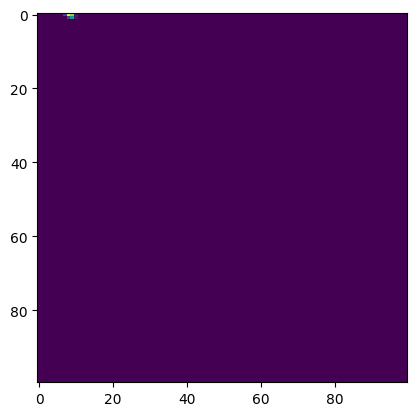

In [6]:
xmin=-5
xmax=5
func = lambda X: np.sin(np.sum(X, axis=1))

test_dim=100
ndim = 2

for dim in [4, 20, 40, 60]:
    grid = [(xmin, xmax, dim)]*ndim
    test_grid = [(xmin, xmax, test_dim)]*ndim

    x = grid_points(test_grid)
    W = get_simplicial_basis(x, grid)
    forg = func(x)

    g = grid_points(grid)
    fg = func(g)
    fint = W*fg
    test_shape = [test_grid[0][2], test_grid[1][2]]
    im = W[:,5].todense().reshape(test_shape)
    plt.imshow(im)

    print("Mae: ", np.mean(np.abs(fint - forg)), dim)

In [7]:
epsilon = 0
xmin=-5 - epsilon
xmax=5 + epsilon
test_dim=5

ndim = 1
xmin=-5
xmax=5

func = lambda X: np.sin(np.sum(X, axis=1))

for dim in [2, 20, 40, 60]:

    grid = [(xmin, xmax, dim)]*ndim
    test_grid = [(xmin, xmax, test_dim)]*ndim
    x = grid_points(test_grid)
    x = torch.from_numpy(x) #.to(torch.float32)
    
    indices, values = get_simplicial_basis(x, grid)
    grid_sz = [i[-1] for i in grid]
    W = InterpolationUtils.unpack_and_sparse_tensor(indices.clip(max=np.prod(grid_sz)-1), values, x.shape[0], np.prod(grid_sz))

    forg = func(x.numpy())
    g = grid_points(grid)
    fg = func(g)
    fint = W.matmul(torch.from_numpy(fg)).numpy()

    print("Mae: ", np.mean(np.abs(fint - forg)), dim)
    break

Mae:  0.4311737125742102 2


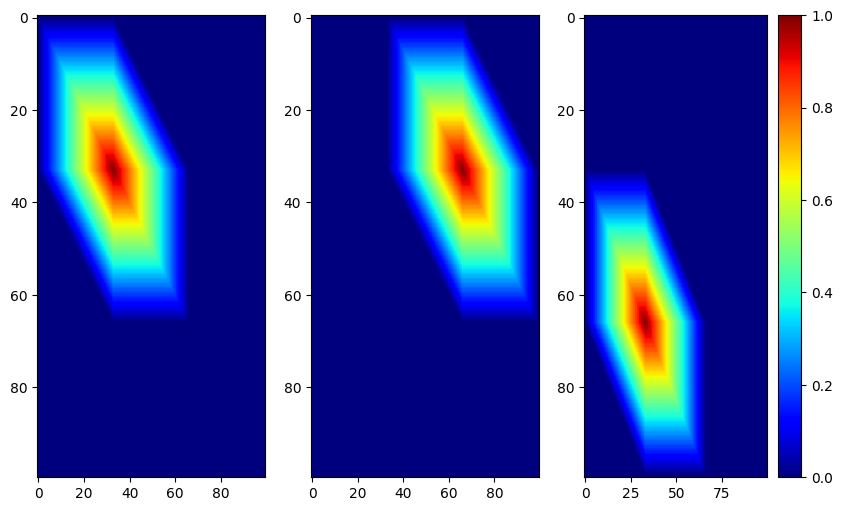

In [8]:
xmin=0
xmax=1
dim=4
test_dim=100

grid = [(xmin, xmax, dim), (xmin, xmax, dim)]
test_grid = [(xmin, xmax, test_dim), (xmin, xmax, test_dim)]

x = grid_points(test_grid)
W = get_simplicial_basis(x, grid)

data = [W[:,i].todense().reshape(test_shape) for i in [5, 6, 9]]

# fig, axs = plt.subplots(1, 3, figsize=(10, 8), tight_layout=True)

# for i, dat in enumerate(data):
#     im2 = axs[i].imshow(dat, cmap='jet')
#     axs[i].set_yticks([])
#     axs[i].set_xticks([])
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(data[0], cmap='jet', aspect='auto')
plt.subplot(1, 3, 2)
plt.imshow(data[1], cmap='jet', aspect='auto')
plt.subplot(1, 3, 3)
plt.imshow(data[2], cmap='jet', aspect='auto')

plt.colorbar()
plt.show()